In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import numpy as np
from tqdm import tqdm

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

####generating data

In [2]:
def get_carries(p, q):
    k = len(str(max(p, q))) + 1
    carries = ''
    cur_carrie = 0
    for i in range(k-1):
        d1 = p % 10
        d2 = q % 10
        cur_carrie = int((cur_carrie + d1 + d2) // 10)
        carries += str(cur_carrie)
        p /= 10
        q /= 10
    return carries[::-1]


# n - number of examples
# in range [a, b)
def generate_data(n, a, b):
    train = open('train.txt', 'w')
    test = open('test.txt', 'w')
    all_data = set()
    k = 0
    while k < n:
        p = random.randint(a, b)
        q = random.randint(a, b)
        if (p, q) not in all_data and (q, p) not in all_data:
            all_data.add((p, q))
            k += 1
            carries = get_carries(p, q)
            # print(f"{p} + {q} = {p + q}, carries = {carries}")
            s = f'{p} {q} {carries} {p+q}\n'
            if k < int(0.7 * n):
                train.write(s)
            else:
                test.write(s)

In [ ]:
generate_data(1000, 0, 10000)

####loading data

In [41]:
def get_ohe(num, k):
    a = list(map(int, str(num)))
    ohe = torch.zeros((k, 10))
    ohe[np.arange(k - len(a), k), a] = 1
    return ohe

def process_digits(a, b, c, d, k):
    ohe_a = get_ohe(a, k)
    ohe_b = get_ohe(b, k)
    inp = torch.stack((ohe_a, ohe_b, torch.zeros((k, 10)), torch.zeros((k, 10))))

    ohe_c = get_ohe(c, k)
    ohe_d = get_ohe(d, k)
    trg = torch.stack((torch.zeros((k, 10)), torch.zeros((k, 10)), ohe_c, ohe_d))

    return inp, trg

class DigitsDataset(Dataset):
    def __init__(self, file):
        """
        Dataset with texts, supporting BPE tokenizer
        :param data_file: txt file containing texts
        :param train: whether to use train or validation split
        :param sp_model_prefix: path prefix to save tokenizer model
        :param vocab_size: sentencepiece tokenizer vocabulary size
        :param normalization_rule_name: sentencepiece tokenizer normalization rule
        :param model_type: sentencepiece tokenizer model type
        :param max_length: maximal length of text in tokens
        """
        self.data = []
        with open(file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            a, b, c, d = map(str, line.split())
            k = max(len(a), len(b)) + 1
            inp, trg = process_digits(a, b, c, d, k)
            self.data.append((inp, trg, k, int(d)))

    def __len__(self):
        """
        Size of the dataset
        :return: number of texts in the dataset
        """
        return len(self.data)

    def __getitem__(self, item: int):
        """
        return pair of german and english text
        """
        return self.data[item]

In [42]:
train_set = DigitsDataset('train.txt')
test_set = DigitsDataset('test.txt')

In [46]:
train_loader = DataLoader(train_set, shuffle=True)
val_loader = DataLoader(test_set, shuffle=False)

In [50]:
for i, (inp, trg, _, d )in enumerate(val_loader):
    if i == 2:
        break
    print(inp.shape, trg.shape, d)

torch.Size([1, 4, 5, 10]) torch.Size([1, 4, 5, 10]) tensor([15640])
torch.Size([1, 4, 5, 10]) torch.Size([1, 4, 5, 10]) tensor([17811])


####training process

In [53]:
def ohe_to_num(ohe): # s x 10
    digits = torch.argmax(ohe, dim=1).tolist()[::-1]
    num = 0
    mul = 1
    for d in digits:
      num = num + d * mul
      mul *= 10
    return num


def ohe_to_str(ohe): # s x 10
    digits = torch.argmax(ohe, dim=1).tolist()
    num = ''
    for d in digits:
      num += str(d)
    return num


def ohe_to_exmpl(ohe):
    exmpl = ohe_to_str(ohe[0]) + ' + ' + ohe_to_str(ohe[1]) + ' = ' + ohe_to_str(ohe[3]) 
    exmpl = exmpl + ', carries ' + ohe_to_str(ohe[2]) + '\n'
    return exmpl
    

In [54]:
print(ohe_to_exmpl(inp[0]), ohe_to_exmpl(trg[0]))

00477 + 07676 = 00000, carries 00000
 00000 + 00000 = 08153, carries 00111



In [68]:
def train_epoch(model, optimizer, criterion, loader, tqdm_desc):
    model.train()
    full_loss = 0

    for inp, trg, k, _ in tqdm(loader, desc=tqdm_desc):
        cur_inp = inp[0]
        trg = trg[0]
        cur_loss = 0
        for i in range(k):
            cur_inp = cur_inp.to(device)
            trg = trg.to(device)
            optimizer.zero_grad()
            out = model(cur_inp) # bs x 4 x s x 10
            zone_of_interest = out[2:, k-i-1, :]
            trg_zone_of_interest = trg[2:, k-i-1, :]
            loss = criterion(zone_of_interest, trg_zone_of_interest)
            loss.backward()
            optimizer.step()
            cur_loss += loss.item()
            cur_inp[2:, k-i-1, torch.argmax(zone_of_interest, dim=1)] = 1
        cur_loss /= k
        full_loss += cur_loss
      
    return full_loss / len(loader)


@torch.no_grad()
def validate_epoch(model, criterion, loader, tqdm_desc):
    model.eval()
    full_loss = 0
    accuracy = 0

    for inp, trg, k, real_num in tqdm(loader, desc=tqdm_desc):
        cur_inp = inp[0]
        trg = trg[0]
        cur_loss = 0
        for i in range(k):
            cur_inp = cur_inp.to(device)
            trg = trg.to(device)
            out = model(cur_inp) # 4 x s x 10
            zone_of_interest = out[2:, k-i-1, :]
            trg_zone_of_interest = trg[2:, k-i-1, :]
            loss = criterion(zone_of_interest, trg_zone_of_interest)
            cur_loss += loss.item()
            cur_inp[2:, k-i-1, torch.argmax(zone_of_interest, dim=1)] = 1
        cur_loss /= k
        full_loss += cur_loss
        out_num = ohe_to_num(out[-1])
        accuracy += int(real_num[0] == out_num)

    return full_loss / len(loader), accuracy / len(loader)


def plot_losses(train_losses, val_losses):
    clear_output()
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='train')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='val')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
  

def train(model, optimizer, train_loader, val_loader, num_epochs):
    train_losses, val_losses, accs = [], [], []
    criterion = nn.BCELoss()

    for epoch in range(1, num_epochs + 1):
        train_loss = train_epoch(model, optimizer, criterion, train_loader, 
                                 f'Training {epoch}/{num_epochs}')
        val_loss, val_acc = validate_epoch(model, criterion, val_loader, 
                                 f'Testing {epoch}/{num_epochs}')
        
        train_losses += [train_loss]
        val_losses += [val_loss]
        accs += [val_acc]

        plot_losses(train_losses, val_losses)
        print('val accuracy', val_acc)

**model**

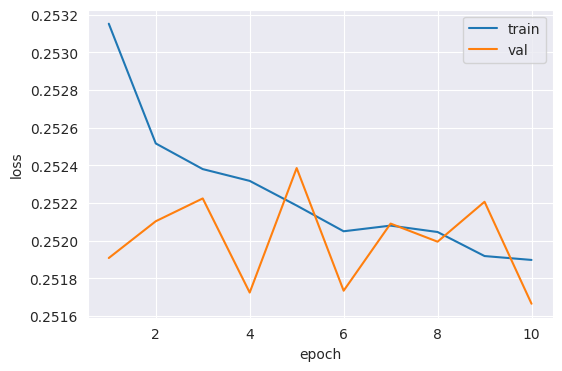

val accuracy 0.0


In [69]:
n_features = 10
hidden = 256
model = nn.Sequential(
    nn.Linear(n_features, hidden),
    nn.ReLU(),
    nn.Linear(hidden, hidden),
    nn.ReLU(),
    nn.Linear(hidden, n_features),
    nn.Softmax(dim=-1)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(model, optimizer, train_loader, val_loader, num_epochs=10)

#### promt tuning openai-gpt

In [ ]:
!pip install transformers

In [71]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='openai-gpt', device=device)
set_seed(42)

In [73]:
s = ''
with open('simple.txt', 'r') as f:
    lines = f.readlines()
for line in lines:
    s += line
print(s)

Q: What is 8 plus 7?
A: 1,5

Q: What is 1,1 plus 2?
A: 1,3

Q: What is 2 plus 6?
A: 8

Q: What is 7 plus 2?
A: 


In [75]:
print(generator(s, max_length=50)[0]['generated_text'])

Q: What is 8 plus 7?
A: 1,5

Q: What is 1,1 plus 2?
A: 1,3

Q: What is 2 plus 6?
A: 8

Q: What is 7 plus 2?
A:  what


#### promt-tuning gpt2

In [76]:
generator = pipeline('text-generation', model='gpt2', device=device)

In [78]:
print(generator(s, max_length=100)[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Q: What is 8 plus 7?
A: 1,5

Q: What is 1,1 plus 2?
A: 1,3

Q: What is 2 plus 6?
A: 8

Q: What is 7 plus 2?
A: ???

Q: What is 9 plus 4?

A: 8

Q: What is 9 plus 4?

A: 9 plus 7!!! What is 9 plus 9?
